In [1]:
import pandas as pd

In [2]:
df = pd.read_excel("df_joined.xlsx") #reading excel file

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52922 entries, 0 to 52921
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TransactionId    52922 non-null  int64 
 1   UserId           52922 non-null  int64 
 2   VisitYear        52922 non-null  int64 
 3   VisitMonth       52922 non-null  int64 
 4   VisitMode        52922 non-null  object
 5   AttractionId     52922 non-null  int64 
 6   Rating           52922 non-null  int64 
 7   Attraction       52922 non-null  object
 8   VisitYear_cat    52922 non-null  int64 
 9   VisitMonth_name  52922 non-null  object
 10  Continent        52922 non-null  object
 11  Region           52922 non-null  object
 12  Country          52922 non-null  object
 13  CityName         52922 non-null  object
dtypes: int64(7), object(7)
memory usage: 5.7+ MB


In [4]:
df.drop(columns=["VisitYear_cat", "VisitMonth_name"], inplace=True)

checking how features numerical corrleates with  Rating

In [5]:
# User-based features
user_avg = df.groupby("UserId")["Rating"].mean().rename("User_AvgRating")
user_total = df.groupby("UserId")["Rating"].count().rename("User_TotalTrips")

In [6]:
# Attraction-based features
attr_avg = df.groupby("AttractionId")["Rating"].mean().rename("Attraction_AvgRating")
attr_total = df.groupby("AttractionId")["Rating"].count().rename("Attraction_TotalTrips")

In [7]:
# Merge back into original DataFrame
df = df.merge(user_avg, on="UserId", how="left")
df = df.merge(user_total, on="UserId", how="left")
df = df.merge(attr_avg, on="AttractionId", how="left")
df = df.merge(attr_total, on="AttractionId", how="left")

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52922 entries, 0 to 52921
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TransactionId          52922 non-null  int64  
 1   UserId                 52922 non-null  int64  
 2   VisitYear              52922 non-null  int64  
 3   VisitMonth             52922 non-null  int64  
 4   VisitMode              52922 non-null  object 
 5   AttractionId           52922 non-null  int64  
 6   Rating                 52922 non-null  int64  
 7   Attraction             52922 non-null  object 
 8   Continent              52922 non-null  object 
 9   Region                 52922 non-null  object 
 10  Country                52922 non-null  object 
 11  CityName               52922 non-null  object 
 12  User_AvgRating         52922 non-null  float64
 13  User_TotalTrips        52922 non-null  int64  
 14  Attraction_AvgRating   52922 non-null  float64
 15  At

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52922 entries, 0 to 52921
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TransactionId          52922 non-null  int64  
 1   UserId                 52922 non-null  int64  
 2   VisitYear              52922 non-null  int64  
 3   VisitMonth             52922 non-null  int64  
 4   VisitMode              52922 non-null  object 
 5   AttractionId           52922 non-null  int64  
 6   Rating                 52922 non-null  int64  
 7   Attraction             52922 non-null  object 
 8   Continent              52922 non-null  object 
 9   Region                 52922 non-null  object 
 10  Country                52922 non-null  object 
 11  CityName               52922 non-null  object 
 12  User_AvgRating         52922 non-null  float64
 13  User_TotalTrips        52922 non-null  int64  
 14  Attraction_AvgRating   52922 non-null  float64
 15  At

In [11]:
# ------------------------------
# STEP 2: Cyclical Encoding for VisitMonth
# ------------------------------
df["VisitMonth_sin"] = np.sin(2 * np.pi * df["VisitMonth"] / 12)
df["VisitMonth_cos"] = np.cos(2 * np.pi * df["VisitMonth"] / 12)

Random forest regressor

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from xgboost import XGBRegressor

In [13]:
# ------------------------------
# STEP 3: Feature & Target Selection
# ------------------------------
features = [
    "VisitMode", "Continent", "Region", "Country", "CityName",
    "User_TotalTrips", "User_AvgRating",
    "Attraction_TotalTrips", "Attraction_AvgRating",
    "VisitMonth_sin", "VisitMonth_cos"
]
target = "Rating"

X = df[features]
y = df[target]


In [14]:
# ------------------------------
# STEP 4: Preprocessing
# ------------------------------
cat_cols = ["VisitMode", "Continent", "Region", "Country", "CityName"]
num_cols = [
    "User_TotalTrips", "User_AvgRating",
    "Attraction_TotalTrips", "Attraction_AvgRating",
    "VisitMonth_sin", "VisitMonth_cos"
]

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

In [16]:
# ------------------------------
# STEP 5: XGBoost Pipeline
# ------------------------------
xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ))
])

In [17]:
# ------------------------------
# STEP 6: Train-Test Split & Model Fitting
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

In [18]:
# ------------------------------
# STEP 7: Evaluation
# ------------------------------
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"XGBoost R² Score: {r2:.4f}")
print(f"XGBoost Mean Squared Error: {mse:.4f}")


XGBoost R² Score: 0.7324
XGBoost Mean Squared Error: 0.2542


In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# --- Feature 1: avg_sum ---
df["avg_sum"] = df["User_AvgRating"] + df["Attraction_AvgRating"]

# --- Feature 2: match_gap ---
df["match_gap"] = -abs(df["User_AvgRating"] - df["Attraction_AvgRating"])

# --- Feature 3: bias_sum ---
global_mean = df["Rating"].mean()
df["user_bias"] = df["User_AvgRating"] - global_mean
df["attr_bias"] = df["Attraction_AvgRating"] - global_mean
df["bias_sum"] = df["user_bias"] + df["attr_bias"]

# --- Evaluation helper ---
def eval_model(feature_list, label):
    X = df[feature_list]
    y = df["Rating"]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{label:35s} R²={r2:.4f}  MSE={mse:.4f}")

# --- Run comparisons ---
eval_model(["avg_sum"], "avg_sum (User_Avg + Attr_Avg)")
eval_model(["User_AvgRating", "match_gap", "bias_sum"], "User_Avg + match_gap + bias_sum")


avg_sum (User_Avg + Attr_Avg)       R²=0.7027  MSE=0.2825
User_Avg + match_gap + bias_sum     R²=0.7337  MSE=0.2530


In [20]:
# Assume df has: UserId, Attraction, Rating

# Step 1: Global category average
cat_global_avg = df.groupby("Attraction")["Rating"].mean().rename("cat_global_avg")

# Step 2: Per-user category average
user_cat_avg = df.groupby(["UserId", "Attraction"])["Rating"].mean().rename("user_cat_avg")

# Step 3: Merge to get both in one table
affinity_df = user_cat_avg.reset_index().merge(
    cat_global_avg.reset_index(), on="Attraction", how="left"
)

# Step 4: Compute category affinity
affinity_df["category_affinity"] = affinity_df["user_cat_avg"] - affinity_df["cat_global_avg"]

# Step 5: Merge back to main df
df = df.merge(
    affinity_df[["UserId", "Attraction", "category_affinity"]],
    on=["UserId", "Attraction"], how="left"
)


In [21]:
features = [
    "User_AvgRating",
    "category_affinity" ,"bias_sum" 
]

"match_gap" "country_avg_rating","log_user_trips", "log_attr_trips"(least improvement) , "country_avg_rating" ,,"bias_product"

In [22]:

X = df[features]
y = df["Rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")


R²: 0.9249
MSE: 0.0713


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52922 entries, 0 to 52921
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TransactionId          52922 non-null  int64  
 1   UserId                 52922 non-null  int64  
 2   VisitYear              52922 non-null  int64  
 3   VisitMonth             52922 non-null  int64  
 4   VisitMode              52922 non-null  object 
 5   AttractionId           52922 non-null  int64  
 6   Rating                 52922 non-null  int64  
 7   Attraction             52922 non-null  object 
 8   Continent              52922 non-null  object 
 9   Region                 52922 non-null  object 
 10  Country                52922 non-null  object 
 11  CityName               52922 non-null  object 
 12  User_AvgRating         52922 non-null  float64
 13  User_TotalTrips        52922 non-null  int64  
 14  Attraction_AvgRating   52922 non-null  float64
 15  At

In [26]:
import pandas as pd

# Select only the three features + target
cols_to_corr = ["User_AvgRating", "category_affinity", "bias_sum", "Rating"]

# Compute correlation matrix
corr_matrix = df[cols_to_corr].corr()

# Display
print(corr_matrix)


                   User_AvgRating  category_affinity  bias_sum    Rating
User_AvgRating           1.000000           0.848365  0.954473  0.853837
category_affinity        0.848365           1.000000  0.741356  0.913612
bias_sum                 0.954473           0.741356  1.000000  0.839429
Rating                   0.853837           0.913612  0.839429  1.000000


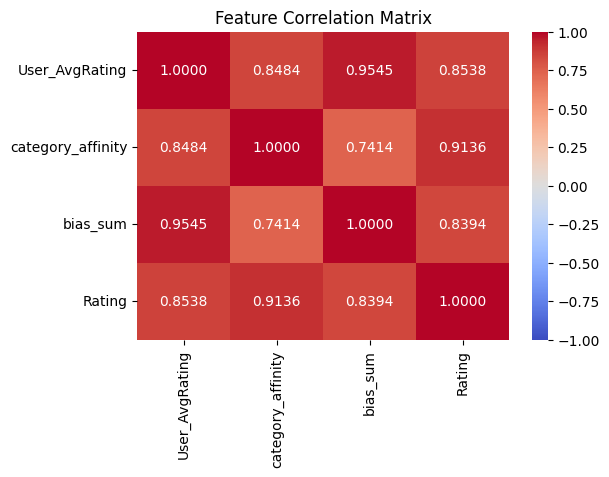

In [27]:


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, fmt=".4f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()



In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# ==== Step 1: Define features & target ====
features = ["User_AvgRating", "category_affinity", "bias_sum"]
target = "Rating"

X = df[features]
y = df[target]

# ==== Step 2: Train-Test Split ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==== Step 3: Train the model ====
model = LinearRegression()
model.fit(X_train, y_train)

# ==== Step 4: Predictions ====
y_pred = model.predict(X_test)

# ==== Step 5: Evaluation ====
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"MSE: {mse:.4f}")

# ==== Step 6: Inspect Coefficients ====
coef_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": model.coef_
})
print("\nModel Coefficients:\n", coef_df)


R² Score: 0.9249
MSE: 0.0713

Model Coefficients:
              Feature  Coefficient
0     User_AvgRating    -1.000101
1  category_affinity     0.999094
2           bias_sum     1.000041


In [44]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Features and target
features = ["User_AvgRating", "category_affinity", "bias_sum"]
target = "Rating"

# Train-test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Separate X and y
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
print(f"R²: {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")


R²: 0.9249
MSE: 0.0713


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52922 entries, 0 to 52921
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TransactionId          52922 non-null  int64  
 1   UserId                 52922 non-null  int64  
 2   VisitYear              52922 non-null  int64  
 3   VisitMonth             52922 non-null  int64  
 4   VisitMode              52922 non-null  object 
 5   AttractionId           52922 non-null  int64  
 6   Rating                 52922 non-null  int64  
 7   Attraction             52922 non-null  object 
 8   Continent              52922 non-null  object 
 9   Region                 52922 non-null  object 
 10  Country                52922 non-null  object 
 11  CityName               52922 non-null  object 
 12  User_AvgRating         52922 non-null  float64
 13  User_TotalTrips        52922 non-null  int64  
 14  Attraction_AvgRating   52922 non-null  float64
 15  At

In [30]:
# Create new DataFrame with selected features + target
df_new = df[["User_AvgRating", "category_affinity", "bias_sum", "Rating"]].copy()

print(df_new.head())


   User_AvgRating  category_affinity  bias_sum  Rating
0             5.0            0.73297  0.951812       5
1             5.0            0.73297  0.951812       5
2             5.0            0.73297  0.951812       5
3             3.0           -1.26703 -1.048188       3
4             3.0           -1.26703 -1.048188       3


In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# --- Columns ---
features = ["User_AvgRating", "category_affinity", "bias_sum"]
target = "Rating"

# --- Train/Test split ---
train_df, test_df = train_test_split(df_new, test_size=0.2, random_state=42)

X_train, y_train = train_df[features], train_df[target]
X_test,  y_test  = test_df[features],  test_df[target]

# --- Train model ---
model = LinearRegression()
model.fit(X_train, y_train)

# --- Predict on test set ---
y_pred = model.predict(X_test)

# --- Evaluate ---
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")

# --- (Optional) Attach predictions to test_df ---
test_with_preds = test_df.copy()
test_with_preds["Predicted_Rating"] = y_pred
print(test_with_preds.head())


R²: 0.9249
MSE: 0.0713
       User_AvgRating  category_affinity  bias_sum  Rating  Predicted_Rating
6927         5.000000           0.732970  0.951812       5          4.999352
15074        5.000000           0.353399  1.331383       5          4.999712
41404        5.000000           0.805191  0.879590       5          4.999284
52668        5.000000           1.461153  0.223628       5          4.998663
35002        3.909091          -0.156944 -0.249184       4          4.000219


The r2 of test and train is almost equal

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Evaluate
print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}")
print(f"Test  R²: {r2_score(y_test, y_test_pred):.4f}")
print(f"Train MSE: {mean_squared_error(y_train, y_train_pred):.4f}")
print(f"Test  MSE: {mean_squared_error(y_test, y_test_pred):.4f}")


Train R²: 0.9261
Test  R²: 0.9249
Train MSE: 0.0695
Test  MSE: 0.0713


In [25]:
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [26]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Train model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [28]:
# Predictions (optional)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [29]:
# Save model to a .pkl file
with open("linear_regression_model.pkl", "wb") as file:
    pickle.dump(lr, file)

print("✅ Model saved as 'linear_regression_model.pkl'")


✅ Model saved as 'linear_regression_model.pkl'


In [51]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# ==== Step 1: Define features & target ====
features = ["User_AvgRating", "category_affinity", "bias_sum"]
target = "Rating"

X = df[features]
y = df[target]

# ==== Step 2: Train/Test split ====
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==== Step 3: Model ====
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,          # let trees grow; tune if overfitting
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",     # good default for RF
    n_jobs=-1,
    random_state=42
)

# ==== Step 4: Fit ====
rf.fit(X_train, y_train)

# ==== Step 5: Predict & Evaluate ====
y_pred = rf.predict(X_test)
print(f"R²:  {r2_score(y_test, y_pred):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")

# ==== Step 6 (optional): Feature importance ====
import numpy as np
imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("\nFeature importances:\n", imp.round(4))


R²:  0.8968
MSE: 0.0980

Feature importances:
 category_affinity    0.4830
bias_sum             0.2604
User_AvgRating       0.2565
dtype: float64


## Classification problem

In [32]:
# Step 1 — Identify and drop duplicate columns
df = df.loc[:, ~df.columns.duplicated()]

# Step 2 — Drop columns ending in _x or _y if a base name exists
to_drop = []
for col in df.columns:
    if col.endswith(('_x', '_y')):
        base_col = col[:-2]
        if base_col in df.columns:
            to_drop.append(col)

df = df.drop(columns=to_drop)

# Step 3 — (Optional) Verify clean columns
print(df.columns.tolist())
print(df.shape)


['TransactionId', 'UserId', 'VisitYear', 'VisitMonth', 'VisitMode', 'AttractionId', 'Rating', 'Attraction', 'Continent', 'Region', 'Country', 'CityName', 'User_AvgRating', 'User_TotalTrips', 'Attraction_AvgRating', 'Attraction_TotalTrips', 'VisitMonth_sin', 'VisitMonth_cos', 'avg_sum', 'match_gap', 'user_bias', 'attr_bias', 'bias_sum', 'category_affinity']
(52922, 24)


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52922 entries, 0 to 52921
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TransactionId          52922 non-null  int64  
 1   UserId                 52922 non-null  int64  
 2   VisitYear              52922 non-null  int64  
 3   VisitMonth             52922 non-null  int64  
 4   VisitMode              52922 non-null  object 
 5   AttractionId           52922 non-null  int64  
 6   Rating                 52922 non-null  int64  
 7   Attraction             52922 non-null  object 
 8   Continent              52922 non-null  object 
 9   Region                 52922 non-null  object 
 10  Country                52922 non-null  object 
 11  CityName               52922 non-null  object 
 12  User_AvgRating         52922 non-null  float64
 13  User_TotalTrips        52922 non-null  int64  
 14  Attraction_AvgRating   52922 non-null  float64
 15  At

In [9]:
df = df.drop(columns=[
    "User_AvgRating_y",
    "User_TotalTrips_y",
    "Attraction_AvgRating_y",
    "Attraction_TotalTrips_y"
])

print(df.shape)


KeyError: "['User_AvgRating_y', 'User_TotalTrips_y', 'Attraction_AvgRating_y', 'Attraction_TotalTrips_y'] not found in axis"

In [35]:
df = df.rename(columns={
    "User_AvgRating_x": "User_AvgRating",
    "User_TotalTrips_x": "User_TotalTrips",
    "Attraction_AvgRating_x": "Attraction_AvgRating",
    "Attraction_TotalTrips_x": "Attraction_TotalTrips"
})

print(df.columns.tolist())


['TransactionId', 'UserId', 'VisitYear', 'VisitMonth', 'VisitMode', 'AttractionId', 'Rating', 'Attraction', 'Continent', 'Region', 'Country', 'CityName', 'User_AvgRating', 'User_TotalTrips', 'Attraction_AvgRating', 'Attraction_TotalTrips', 'VisitMonth_sin', 'VisitMonth_cos', 'avg_sum', 'match_gap', 'user_bias', 'attr_bias', 'bias_sum', 'category_affinity']


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52922 entries, 0 to 52921
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TransactionId          52922 non-null  int64  
 1   UserId                 52922 non-null  int64  
 2   VisitYear              52922 non-null  int64  
 3   VisitMonth             52922 non-null  int64  
 4   VisitMode              52922 non-null  object 
 5   AttractionId           52922 non-null  int64  
 6   Rating                 52922 non-null  int64  
 7   Attraction             52922 non-null  object 
 8   Continent              52922 non-null  object 
 9   Region                 52922 non-null  object 
 10  Country                52922 non-null  object 
 11  CityName               52922 non-null  object 
 12  User_AvgRating         52922 non-null  float64
 13  User_TotalTrips        52922 non-null  int64  
 14  Attraction_AvgRating   52922 non-null  float64
 15  At

In [37]:
print(df['VisitMode'].value_counts(normalize=True) * 100)

VisitMode
Couples     40.846907
Family      28.749858
Friends     20.679491
Solo         8.546540
Business     1.177204
Name: proportion, dtype: float64


In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [56]:
# Features & target
features = [
    "Continent", "Region", "Country", "CityName",
    "Attraction", "Attraction_AvgRating", "Attraction_TotalTrips",
    "User_AvgRating", "User_TotalTrips",
    "VisitYear", "VisitMonth"
]
target = "VisitMode"

In [57]:
# Split raw data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[target])

# Categorical & numerical columns
cat_cols = ["Continent", "Region", "Country", "CityName", "Attraction", "VisitYear", "VisitMonth"]
num_cols = ["Attraction_AvgRating", "Attraction_TotalTrips", "User_AvgRating", "User_TotalTrips"]

In [58]:
# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

In [59]:
# Model pipeline
clf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))
])

In [60]:
# Fit model
clf_pipeline.fit(train_df[features], train_df[target])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Continent', 'Region',
                                                   'Country', 'CityName',
                                                   'Attraction', 'VisitYear',
                                                   'VisitMonth']),
                                                 ('num', 'passthrough',
                                                  ['Attraction_AvgRating',
                                                   'Attraction_TotalTrips',
                                                   'User_AvgRating',
                                                   'User_TotalTrips'])])),
                ('model',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

In [61]:

# Predictions
y_pred = clf_pipeline.predict(test_df[features])


In [62]:
# Evaluation
print(classification_report(test_df[target], y_pred))

              precision    recall  f1-score   support

    Business       0.51      0.22      0.31       124
     Couples       0.55      0.76      0.64      4324
      Family       0.56      0.51      0.53      3043
     Friends       0.47      0.30      0.37      2189
        Solo       0.58      0.22      0.32       905

    accuracy                           0.54     10585
   macro avg       0.53      0.40      0.43     10585
weighted avg       0.54      0.54      0.52     10585



In [63]:
# --- Imports
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

In [64]:
# --- Your feature lists
cat_cols = ["Continent", "Region", "Country", "CityName", "Attraction", "VisitYear", "VisitMonth"]
num_cols = ["Attraction_AvgRating", "Attraction_TotalTrips", "User_AvgRating", "User_TotalTrips"]
features = cat_cols + num_cols

In [67]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat",
         Pipeline(steps=[
             ("imputer", SimpleImputer(strategy="most_frequent")),
             ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
         ]),
         cat_cols),
        ("num",
         Pipeline(steps=[
             ("imputer", SimpleImputer(strategy="median"))
         ]),
         num_cols),
    ],
    remainder="drop"
)


In [68]:
# --- Classifier with class_weight to fix imbalance
clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        class_weight="balanced",   # <-- key line
        n_estimators=400,
        random_state=42,
        n_jobs=-1
    ))
])

In [69]:
# --- Train / Evaluate
X_train = train_df[features]
y_train = train_df[target]
X_test  = test_df[features]
y_test  = test_df[target]

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Business       0.51      0.24      0.33       124
     Couples       0.54      0.75      0.63      4324
      Family       0.56      0.50      0.53      3043
     Friends       0.46      0.29      0.36      2189
        Solo       0.55      0.23      0.33       905

    accuracy                           0.53     10585
   macro avg       0.52      0.40      0.43     10585
weighted avg       0.53      0.53      0.51     10585



In [70]:
# ===== Imports
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from packaging import version
import sklearn

In [71]:
# ===== Columns & target
target = "VisitMode"
cat_cols = ["Continent", "Region", "Country", "CityName", "Attraction", "VisitYear", "VisitMonth"]
num_cols = ["Attraction_AvgRating", "Attraction_TotalTrips", "User_AvgRating", "User_TotalTrips"]

In [72]:
# ===== Train / test split (stratified)
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df[target]
)

In [73]:
# ===== Feature Engineering transformer (no leakage: learns from train only)
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols, num_cols):
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.freq_maps_ = {}
        self.rank_maps_ = {}
        # columns to add
        self.freq_cols_ = [f"{c}_freq" for c in cat_cols]
        self.add_cat_cols_ = ["Country_Attraction", "Continent_Region", "Region_Country", "Season"]
        self.add_num_cols_ = ["UserTrips_to_AttractionTrips", "RatingDiff", 
                              "Attraction_RatingRank", "Attraction_TripRank"]

    def fit(self, X, y=None):
        X = X.copy()
        # Frequency maps for each categorical col
        for c in self.cat_cols:
            self.freq_maps_[c] = X[c].value_counts(dropna=False).to_dict()

        # Ranks for attraction-level signals (computed on train only)
        # If missing columns, create safe defaults
        if "Attraction_AvgRating" in X.columns:
            rating_rank = X["Attraction_AvgRating"].rank(method="dense")
            self.rank_maps_["Attraction_RatingRank"] = pd.Series(rating_rank.values, index=X.index).to_dict()
        else:
            self.rank_maps_["Attraction_RatingRank"] = {}

        if "Attraction_TotalTrips" in X.columns:
            trips_rank = X["Attraction_TotalTrips"].rank(method="dense")
            self.rank_maps_["Attraction_TripRank"] = pd.Series(trips_rank.values, index=X.index).to_dict()
        else:
            self.rank_maps_["Attraction_TripRank"] = {}

        return self

    def transform(self, X):
        X = X.copy()

        # Frequency-encoded features
        for c in self.cat_cols:
            X[f"{c}_freq"] = X[c].map(self.freq_maps_.get(c, {})).astype("float64")

        # Interactions / geography hierarchy
        X["Country_Attraction"] = (X["Country"].astype(str) + "_" + X["Attraction"].astype(str))
        X["Continent_Region"] = (X["Continent"].astype(str) + "_" + X["Region"].astype(str))
        X["Region_Country"] = (X["Region"].astype(str) + "_" + X["Country"].astype(str))

        # Season from VisitMonth (robust if stored as str)
        month = pd.to_numeric(X["VisitMonth"], errors="coerce")
        season_map = {
            12: "Winter", 1: "Winter", 2: "Winter",
            3: "Spring", 4: "Spring", 5: "Spring",
            6: "Summer", 7: "Summer", 8: "Summer",
            9: "Autumn", 10: "Autumn", 11: "Autumn"
        }
        X["Season"] = month.map(season_map).fillna("Unknown")

        # Numeric engineered features (safe divisions)
        X["UserTrips_to_AttractionTrips"] = X["User_TotalTrips"] / (X["Attraction_TotalTrips"] + 1)
        X["RatingDiff"] = X["User_AvgRating"] - X["Attraction_AvgRating"]

        # Ranks (fallback: compute on-the-fly if missing in map)
        X["Attraction_RatingRank"] = X["Attraction_AvgRating"].rank(method="dense")
        X["Attraction_TripRank"]   = X["Attraction_TotalTrips"].rank(method="dense")

        return X

In [74]:
# ===== Build feature engineer
fe = FeatureEngineer(cat_cols=cat_cols, num_cols=num_cols)

In [75]:
# ===== Final feature lists after FE
engineered_cat = cat_cols + ["Country_Attraction", "Continent_Region", "Region_Country", "Season"]
engineered_num = (
    num_cols
    + [f"{c}_freq" for c in cat_cols]  # freq encodings are numeric
    + ["UserTrips_to_AttractionTrips", "RatingDiff", "Attraction_RatingRank", "Attraction_TripRank"]
)

In [76]:
# ===== Handle OneHotEncoder arg change across sklearn versions
ohe_kwargs = {"handle_unknown": "ignore"}
if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_kwargs["sparse_output"] = False
else:
    ohe_kwargs["sparse"] = False

In [77]:
# ===== Preprocessor: cats (impute+OHE), nums (impute+scale)
preprocess = ColumnTransformer(
    transformers=[
        ("cat",
         Pipeline(steps=[
             ("imputer", SimpleImputer(strategy="most_frequent")),
             ("ohe", OneHotEncoder(**ohe_kwargs))
         ]),
         engineered_cat),
        ("num",
         Pipeline(steps=[
             ("imputer", SimpleImputer(strategy="median")),
             ("scaler", StandardScaler())
         ]),
         engineered_num),
    ],
    remainder="drop"
)

In [78]:
# ===== Full pipeline: FE -> Preprocess -> Model (class weights for imbalance)
clf = Pipeline(steps=[
    ("fe", fe),
    ("preprocess", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"   # <-- key for imbalance
    ))
])

In [79]:
# ===== Train / Evaluate
features = list(set(engineered_cat + engineered_num))  # not strictly needed; pipeline selects inside CT
X_train = train_df  # pipeline selects needed cols internally
y_train = train_df[target]
X_test  = test_df
y_test  = test_df[target]

In [80]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    Business       0.48      0.24      0.32       124
     Couples       0.53      0.73      0.62      4324
      Family       0.54      0.49      0.51      3043
     Friends       0.44      0.29      0.35      2189
        Solo       0.54      0.23      0.32       905

    accuracy                           0.52     10585
   macro avg       0.51      0.40      0.42     10585
weighted avg       0.52      0.52      0.50     10585



checking feature contribution to classification model

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52922 entries, 0 to 52921
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TransactionId          52922 non-null  int64  
 1   UserId                 52922 non-null  int64  
 2   VisitYear              52922 non-null  int64  
 3   VisitMonth             52922 non-null  int64  
 4   VisitMode              52922 non-null  object 
 5   AttractionId           52922 non-null  int64  
 6   Rating                 52922 non-null  int64  
 7   Attraction             52922 non-null  object 
 8   Continent              52922 non-null  object 
 9   Region                 52922 non-null  object 
 10  Country                52922 non-null  object 
 11  CityName               52922 non-null  object 
 12  User_AvgRating         52922 non-null  float64
 13  User_TotalTrips        52922 non-null  int64  
 14  Attraction_AvgRating   52922 non-null  float64
 15  At

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [11]:
# --- Feature lists & target
target = "VisitMode"
cat_cols = ["Continent", "Region", "Country", "CityName", "Attraction", "VisitYear", "VisitMonth"]
num_cols = ["Attraction_AvgRating", "Attraction_TotalTrips", "User_AvgRating", "User_TotalTrips"]
features = cat_cols + num_cols

In [12]:
# --- Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, random_state=42, stratify=df[target]
)

In [13]:
# --- ColumnTransformer for encoding cats (no scaling here, RF doesn't need it)
ct = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

In [14]:
# --- Fit transformer & transform data
X_train_enc = ct.fit_transform(X_train)
X_test_enc = ct.transform(X_test)

In [15]:
# --- Get encoded feature names
cat_feature_names = ct.named_transformers_["cat"].get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([cat_feature_names, num_cols])

In [16]:
# --- Train RandomForest directly
rf = RandomForestClassifier(class_weight="balanced", random_state=42, n_estimators=500)
rf.fit(X_train_enc, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       random_state=42)

In [17]:
# --- Get feature importances
importances = rf.feature_importances_

In [ ]:

feat_imp_df = pd.DataFrame({
    "Feature": all_feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print(feat_imp_df.head(20))

                    Feature  Importance
5268         User_AvgRating    0.098397
5269        User_TotalTrips    0.085553
5267  Attraction_TotalTrips    0.035690
5266   Attraction_AvgRating    0.035593
5247         VisitYear_2016    0.022367
5248         VisitYear_2017    0.018993
5246         VisitYear_2015    0.018140
5249         VisitYear_2018    0.016444
5261           VisitMonth_8    0.014551
5263          VisitMonth_10    0.013700
5258           VisitMonth_5    0.013684
5257           VisitMonth_4    0.013629
5245         VisitYear_2014    0.013570
5262           VisitMonth_9    0.013561
5259           VisitMonth_6    0.013220
5250         VisitYear_2019    0.013087
5260           VisitMonth_7    0.012614
5265          VisitMonth_12    0.012488
5254           VisitMonth_1    0.012470
5256           VisitMonth_3    0.012416


In [ ]:
# --- Target & columns
target = "VisitMode"

# True categoricals (keep numeric features separate)
cat_cols = ["Continent", "Region", "Country", "CityName", "Attraction"]
num_cols = ["VisitYear", "VisitMonth", "Attraction_AvgRating", 
            "Attraction_TotalTrips", "User_AvgRating", "User_TotalTrips"]

features = cat_cols + num_cols

# --- Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, random_state=42, stratify=df[target]
)

from sklearn.feature_selection import chi2
from sklearn.preprocessing import OneHotEncoder

# Encode categoricals
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = enc.fit_transform(df[cat_cols])
chi_vals, p_vals = chi2(X_cat, df[target].factorize()[0])

chi_df = pd.DataFrame({"Feature": enc.get_feature_names_out(cat_cols), "Chi2": chi_vals, "p-value": p_vals})
print(chi_df.sort_values(by="Chi2", ascending=False))
